<a href="https://colab.research.google.com/github/zhabkazhaba/nlp-notebooks/blob/main/spamclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random as rand
import time

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import kagglehub
from kagglehub import KaggleDatasetAdapter

from itertools import product

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "bayes2003/emails-for-spam-or-ham-classification-enron-2006",
    "email_origin.csv",
)

text_column = "origin"
label_column = "label"

In [23]:
df.head(5)

,label,origin
0,0,Subject: re : wolf - reply - reply - reply\n\n...
1,0,Subject: hilcorp old ocean\n\ni have continued...
2,0,Subject: merchanting metals update\n\nseveral ...
3,0,"Subject: meter 6461 , concorde churchill\n\non..."
4,0,Subject: weekly deal report\n\nattached is the...


In [24]:
def preprocess_string(text, stop_set, stemmer):
  text = word_tokenize(text)
  filtered_text = [tok.lower() for tok in text if not tok.lower() in stop_set and not tok.isdigit()]
  stemmed_text = [stemmer.stem(tok) for tok in filtered_text]

  return stemmed_text

In [25]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))
stop_plus = set([":", ",", "/", "{", "}", ".", ";", "#", "'", "(", ")", "[", "]", "!", "?", "-", "%", "@", "subject", ">", "=", "<", "+", "-", "|", "*", "_"])
result_set = stop_words.union(stop_plus)

df[text_column] = df[text_column].map(lambda x: preprocess_string(x, result_set, stemmer))

df.head(5)

,label,origin
0,0,"[wolf, repli, repli, repli, wrong, bill, grace..."
1,0,"[hilcorp, old, ocean, continu, hilcorp, old, o..."
2,0,"[merchant, metal, updat, sever, relat, issu, r..."
3,0,"[meter, concord, churchil, one, year, rate, on..."
4,0,"[week, deal, report, attach, week, deal, repor..."


## Анализ датасета

In [26]:
def generate_word_counts(sentences, labels):
  word_dict = {}
  for sent_i in range(len(sentences)):
    for word in sentences[sent_i]:
      key = (word, labels[sent_i])
      if key in word_dict:
        word_dict[key] += 1
      else:
        word_dict[key] = 1

  return word_dict

In [27]:
def plot_spam_distribution():
  labels = df[label_column].value_counts().index
  sizes = df[label_column].value_counts().values
  colors = ["#79EF81", "#EC7171"]

  plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%")
  plt.axis("equal")
  plt.show()

In [28]:
def plot_common_words(wdict, top_n=8, chosen_label=-1):
  sorted_words = sorted(wdict.items(), key=lambda x: x[1], reverse=True)
  if chosen_label != -1:
    sorted_words = [(key, count) for key, count in sorted_words if key[1] == chosen_label]

  sorted_words = sorted_words[:top_n]

  words_labels = [f"{word} ({label})" for (word, label), count in sorted_words]
  counts = [count for (_, _), count in sorted_words]

  plt.figure(figsize=(12, 6))
  plt.barh(words_labels, counts, color='skyblue')
  plt.xlabel("Frequency")
  plt.ylabel("Word (label)")
  plt.title(f"Top {top_n} most common words")
  plt.gca().invert_yaxis()
  plt.show()

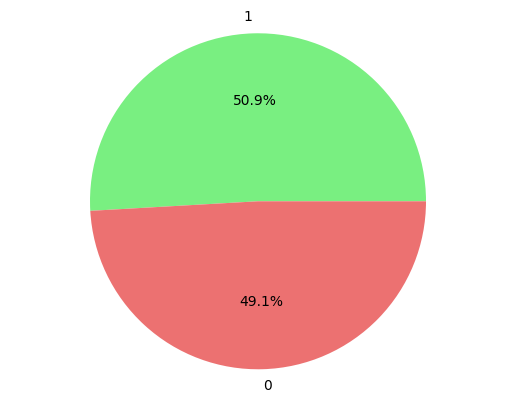

In [29]:
plot_spam_distribution()

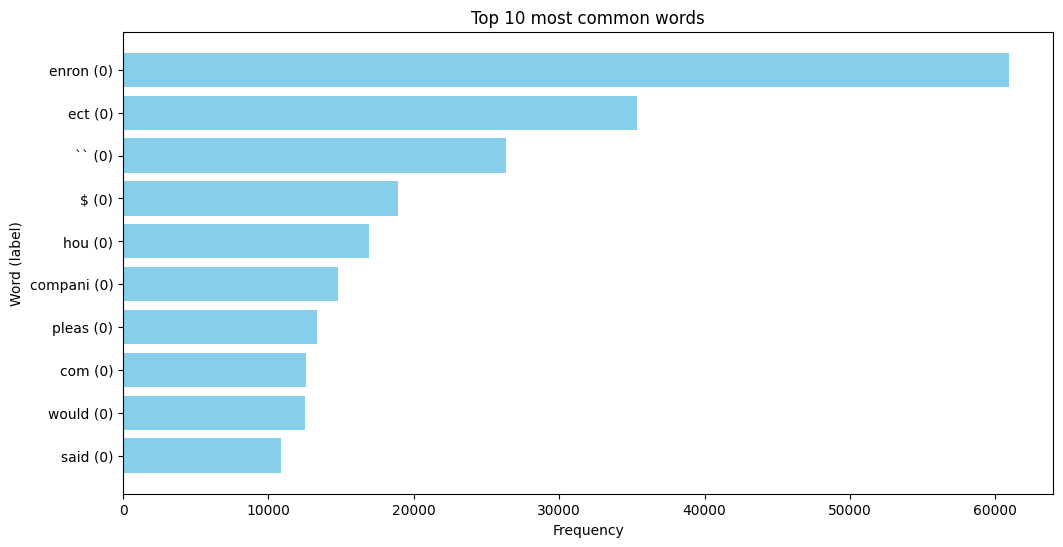

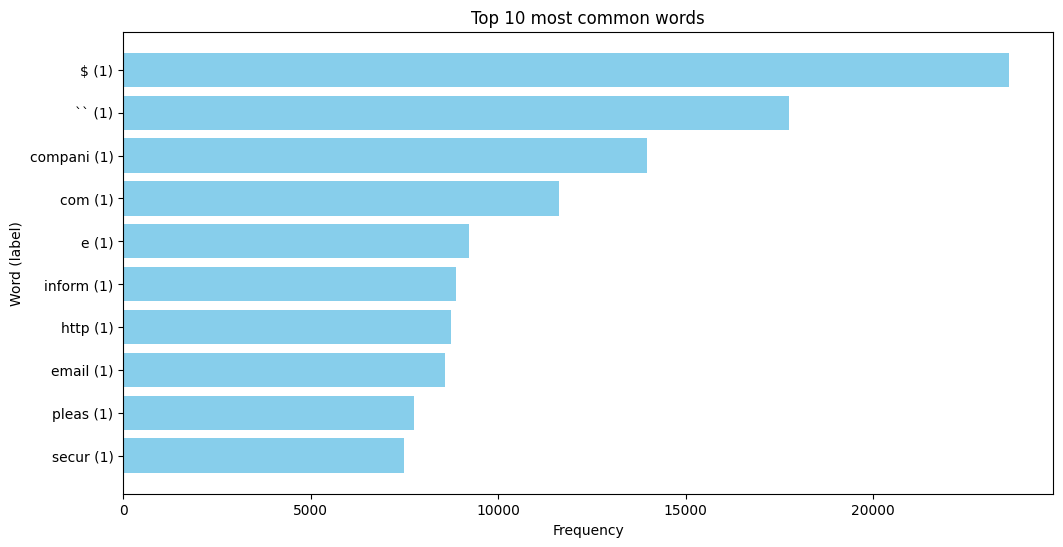

In [30]:
d = generate_word_counts(df[text_column].tolist(), df[label_column].tolist())

plot_common_words(d, 10, 0)
plot_common_words(d, 10, 1)

## Обучение модели

In [31]:
options = {"ngram_range" : [(1,1), (1,2), (1,3)],
           "train_size" : [0.7, 0.8, 0.9],
           "model" : [MultinomialNB(), GaussianNB(), LogisticRegression()]}

In [36]:
fixed_state = 2345
models = []

for ngram, size, model in product(options["ngram_range"], options["train_size"], options["model"]):
  X_tokens = df[text_column].tolist()
  X_text = [' '.join(tokens) for tokens in X_tokens]
  y = df[label_column].tolist()
  X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, train_size = size, random_state = fixed_state)

  vectorizer = TfidfVectorizer(ngram_range = ngram, max_features=15000)
  X_train_vec = vectorizer.fit_transform(X_train_text).toarray()
  X_test_vec = vectorizer.transform(X_test_text).toarray()

  mod = model

  start_time = time.time()
  mod.fit(X_train_vec, y_train)
  end_time = time.time()
  training_time = end_time - start_time
  codename = f"{ngram}-{size}-{mod.__class__.__name__}"
  models.append((codename, mod))

  y_pred = mod.predict(X_test_vec)

  accuracy = accuracy_score(y_test, y_pred)
  if mod.__class__.__name__ == "LogisticRegression":
    iters = mod.n_iter_
  else:
    iters = 0
  print(f"Configuration: Ngram range: {ngram} - Training dataset size: {size} - Model: {mod.__class__.__name__}, \nAccuracy: {accuracy:.4f} - Training time: {training_time:.2f} - Iters: {iters}")

Configuration: Ngram range: (1, 1) - Training dataset size: 0.7 - Model: MultinomialNB, 
Accuracy: 0.9863 - Training time: 1.65 - Iters: 0
Configuration: Ngram range: (1, 1) - Training dataset size: 0.7 - Model: GaussianNB, 
Accuracy: 0.9472 - Training time: 7.35 - Iters: 0
Configuration: Ngram range: (1, 1) - Training dataset size: 0.7 - Model: LogisticRegression, 
Accuracy: 0.9854 - Training time: 9.35 - Iters: [17]
Configuration: Ngram range: (1, 1) - Training dataset size: 0.8 - Model: MultinomialNB, 
Accuracy: 0.9868 - Training time: 1.54 - Iters: 0
Configuration: Ngram range: (1, 1) - Training dataset size: 0.8 - Model: GaussianNB, 
Accuracy: 0.9444 - Training time: 8.94 - Iters: 0
Configuration: Ngram range: (1, 1) - Training dataset size: 0.8 - Model: LogisticRegression, 
Accuracy: 0.9868 - Training time: 21.41 - Iters: [33]
Configuration: Ngram range: (1, 1) - Training dataset size: 0.9 - Model: MultinomialNB, 
Accuracy: 0.9849 - Training time: 1.72 - Iters: 0
Configuration: N

Проверка модели:

In [39]:
user_text = str(input(""))
user_text_tok = preprocess_string(user_text, result_set, stemmer)
print(user_text_tok)
user_text = [' '.join(tokens) for tokens in user_text_tok]
user_text_vec = vectorizer.transform(user_text).toarray()

prediction = mod.predict(user_text_vec)

print(f"Predicted class: {prediction[0]}")

FREE MONEY GET YOUR GIFT RIGHT NOW JOIN JOIN JOIN TOTALLY LEGIT SUBSCRIBE HERE $$$ $
['free', 'money', 'get', 'gift', 'right', 'join', 'join', 'join', 'total', 'legit', 'subscrib', '$', '$', '$', '$']
Predicted class: 1
